In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate

plt.close('all') 

xMin = 0
xMax = 1
yMin = 0
yMax = 1
xDelta = xMax - xMin
yDelta = yMax - yMin  # rectangle dimensions
areaTotal = xDelta * yDelta

numbSim = 10 ** 3  # number of simulations

# Point process parameters
def fun_lambda(x, y):
    return 500*(x**4 + y**4)

###START -- find maximum lambda -- START ###
# For an intensity function lambda, given by function fun_lambda,
# finds the maximum of lambda in a rectangular region given by
# [xMin,xMax,yMin,yMax].
def fun_Neg(x):
    return -fun_lambda(x[0], x[1])  # negative of lambda
#fun_Neg = lambda x: -fun_lambda(x[0], x[1])  # negative of lambda

np.random.seed(777)
xy0 = [(xMin + xMax) / 2, (yMin + yMax) / 2]  # initial value(ie centre)
# Find largest lambda value
resultsOpt = minimize(fun_Neg, xy0, bounds=((xMin, xMax), (yMin, yMax)))
lambdaNegMin = resultsOpt.fun  # retrieve minimum value found by minimize
lambdaMax = -lambdaNegMin


###END -- find maximum lambda -- END ###

# define thinning probability function
def fun_p(x, y):
    return fun_lambda(x, y) / lambdaMax
#fun_p = lambda x, y: fun_lambda(x, y) / lambdaMax

# for collecting statistics -- set numbSim=1 for one simulation
np.random.seed(777)
numbPointsRetained = np.zeros(numbSim)  # vector to record number of points
for ii in range(numbSim):
    # Simulate a Poisson point process
    numbPoints = np.random.poisson(areaTotal * lambdaMax)  # Poisson number of points
    xx = np.random.uniform(0, xDelta, ((numbPoints, 1))) + xMin  # x coordinates of Poisson points
    yy = np.random.uniform(0, yDelta, ((numbPoints, 1))) + yMin  # y coordinates of Poisson points

    # calculate spatially-dependent thinning probabilities
    p = fun_p(xx, yy)

    # Generate Bernoulli variables (ie coin flips) for thinning
    booleRetained = np.random.uniform(0, 1, ((numbPoints, 1))) < p  # points to be retained

    # x/y locations of retained points
    xxRetained = xx[booleRetained]
    yyRetained = yy[booleRetained]
    numbPointsRetained[ii] = xxRetained.size

In [2]:
def csr(lam, window=[0, 1, 0, 1]):
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min) * (x_max-x_min)
    N = np.random.poisson(lam * area)
    x_list = np.random.uniform(x_min, x_max, N)
    y_list = np.random.uniform(y_min, y_max, N)
    return np.c_[x_list, y_list]

csr = csr(xxRetained.shape)

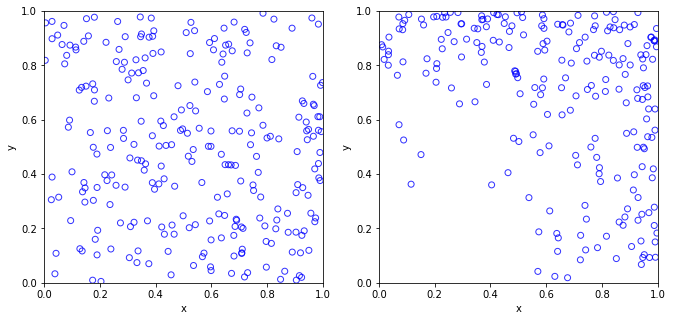

In [3]:
# Plotting
plt.figure(figsize=(11,5))
plt.subplot(121)
plt.scatter(csr[:, 0], csr[:, 1], fc='none', ec='b', alpha=0.8)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x');
plt.ylabel('y');
plt.subplot(122)
plt.scatter(xxRetained, yyRetained, fc='none', ec='b', alpha=0.8);
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x');
plt.ylabel('y');

# run empirical test on number of points generated
if numbSim >= 10:
    # total mean measure (average number of points)
    LambdaNumerical = integrate.dblquad(fun_lambda, xMin, xMax, lambda x: yMin, lambda y: yMax)[0];
    # Test: as numbSim increases, numbPointsMean converges to LambdaNumerical
    numbPointsMean = np.mean(numbPointsRetained);
    # Test: as numbSim increases,numbPointsVar converges to LambdaNumerical
    numbPointsVar = np.var(numbPointsRetained);


plt.savefig('homo vs inhomo', dpi=300, bbox_inches='tight')